In [115]:
import sys
sys.path.append('../..')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
import spatialpy
import numpy
import matplotlib.pyplot as plt


In [117]:
class All(spatialpy.SubDomain):
    def inside(self, x, on_boundary):
        return True

class Lid(spatialpy.SubDomain):
    def inside(self, x, on_boundary):
        mask = (x[1] >=1.0)
        return mask

In [118]:
class Lid_Driven_Cavity(spatialpy.Model):
    """ Lid driven cavity problem
    Description: box with Dirichlet boundary conditions in all 4 walls
    Top wall: moves with constant velocity Vo
    All other walls: stationary (no-slip)
    Wall lengths: height = 1, width = 1 (2D case)
  
              vx=Vo, vy=0
              __ __ __ __
             |           |
             |           |
    vx=vy=0  |           |  vx=vy=0
             |           |
             |__ __ __ __|
             
                vx=vy=0
    
    """

    def __init__(self, model_name="lid_driven_cavity"):
        spatialpy.Model.__init__(self,model_name)
        
        
        
        # System constants
        Vo = 1.              # lid velocity
        nxF,nyF = 50,50      # number of fluid particles in x and y-direction
        nu  = 1.             # fluid viscosity
        L   = 1.             # characteristic lenght of the cavity (= width = height)
        nW  = 3              # number of wall points
        rho = 1.             # fluid density

        # Discretization
        nxTot = nxF + 2*nW # total number of particles in x-direction (including walls)
        nyTot = nyF + 2*nW # total number of particles in y-direction (including walls)
        
        # Compute domain bounds (including the boundary)
        dx,dy = L/(nxF-1),L/(nyF-1)
        xLim = ((-L/2-(nW-1)*dx),L/2+(nW-1)*dx)
        yLim = ((-L/2-(nW-1)*dy),L/2+(nW-1)*dy)
        
        # Compute volume and mass per particle
        vol = (xLim[1]-xLim[0])*(yLim[1]-yLim[0])*1.0 # in 2D simulations, consider z-lenght = 1
        mPP = rho*vol/(nxTot*nyTot)                   # density * total volume / total number of particles
        
        # Create mesh object
        self.mesh = spatialpy.Mesh.create_2D_domain(xLim ,yLim , nxTot, nyTot, type_id=1, mass=mPP, nu = nu, fixed=False)
        
        #A = spatialpy.Species(name="A",diffusion_constant=0.01)
        #self.add_species([A])

        # Define Subdomains
        self.add_subdomain(All(), 1)             # total subdomain, type 1
        self.add_subdomain(Lid(), 2, fixed=True) # lid subdomain, type 2

        # Boundary conditions
        # They should go here... define subdomain top with velocity Vo
        
        # Time span
        self.timespan(numpy.linspace(0,5,1000))

In [119]:
# Creates the model object
model = Lid_Driven_Cavity()

In [120]:
# Run the model object
%time result = model.run()

Reading stdout/stderr from process:
gcc -c -o linked_list.o /Users/bjacob/Desktop/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/src/linked_list.c -I/Users/bjacob/Desktop/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/include/ -O3 -Wall 
gcc -c -o particle.o /Users/bjacob/Desktop/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/src/particle.c -I/Users/bjacob/Desktop/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/include/ -O3 -Wall 
gcc -c -o simulate.o /Users/bjacob/Desktop/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/src/simulate.c -I/Users/bjacob/Desktop/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/include/ -O3 -Wall 
gcc -c -o count_cores.o /Users/bjacob/Desktop/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/src/count_cores.c -I/Users/bjacob/Desktop/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/include/ -O3 -Wall 
gcc -c -o output.o /Users/bjacob/Desktop/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/src/output.c -I/Users/bjacob/Desktop/SpatialPy/spatialpy/ssa_s

SimulationError: Compilation of solver failed, return_code=2

In [121]:
# Plot_step access the result object and search for the specified key to plot
def plot_step(key='type',index=0,time=0):
    pts, data = result.read_step(time)
    plt.figure(figsize=(15,10) )       
    if (key == 'v'):
        d = data[key]
        d = [d[i][index] for i in range(0,len(d))]
    else:
        d = data[key]
    plt.scatter(pts[:,0],pts[:,1],c=d)
    plt.axis('equal')
    plt.colorbar()
    plt.title('t={0}'.format(time))
    plt.xticks(numpy.arange(-0.6, 0.7, 0.1)) 
    plt.yticks(numpy.arange(-0.6, 0.7, 0.1)) 
    plt.grid(linestyle='--', linewidth=1)

    
def plot_all(key='type'):
    for i,t in enumerate(result.get_timespan()):
        plot_step(i,key)

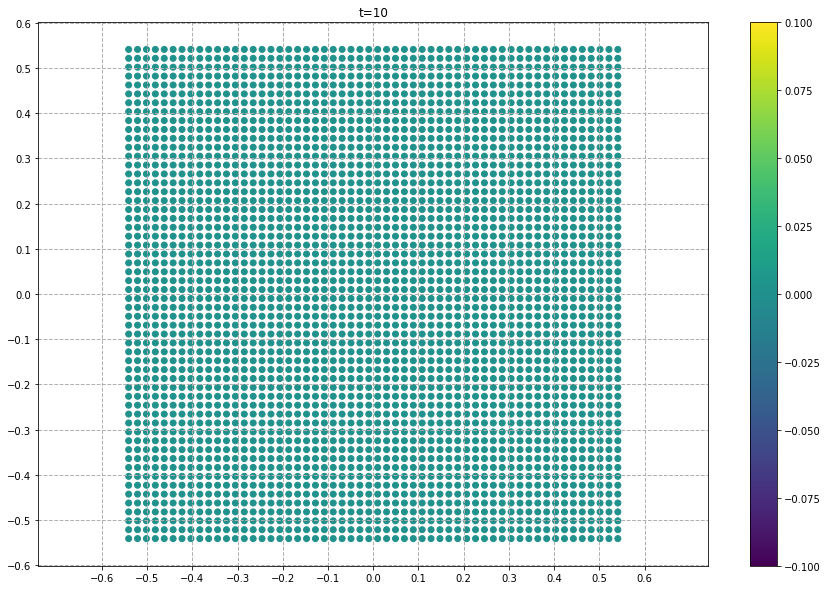

In [122]:
# Plot velocity (index 0, i.e., vx) at timestep 10
plot_step('v',index=0,time=10)

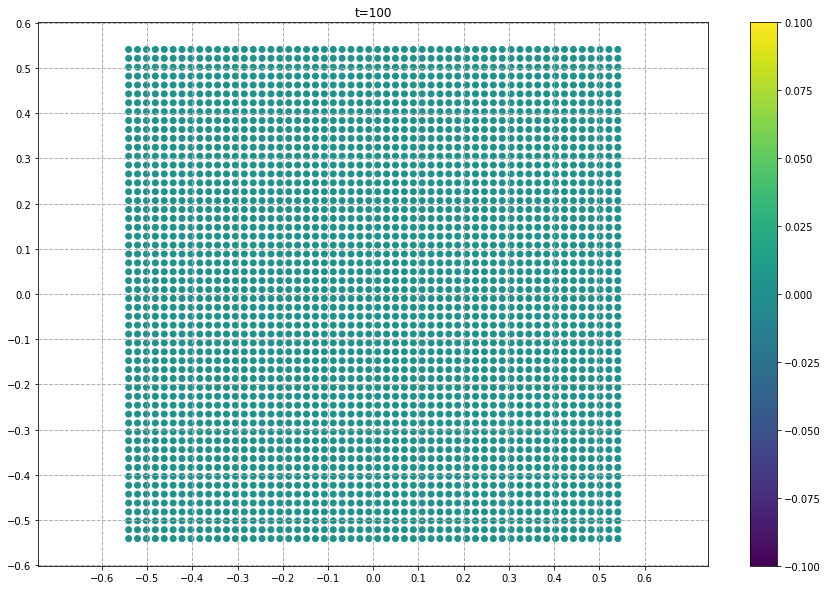

In [123]:
# Plot concentration of species A (discrete) at timestep 100
plot_step('D[A]',time=100)

In [ ]:
# To access data from a given timestep, use the read_step method
# e.g., read data from time step 10
pts,data = result.read_step(10)
print(pts)
print(data)